In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install -U timm
!pip install -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: timm
    Found existing installation: timm 1.0.20
    Uninstalling timm-1.0.20:
      Successfully uninstalled timm-1.0.20


In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
IMAGES_DIR = '/kaggle/input/flickr30k/flickr30k_images'
CAPTIONS_FILE = '/kaggle/input/flickr30k/captions.txt'

with open(CAPTIONS_FILE) as captions:
    lines = captions.readlines()

get_captions = {}
all_captions = []
existing_images = set(os.listdir(IMAGES_DIR))

for caption in lines:
    data = caption.strip().split('.jpg,')
    if len(data) < 2: continue
    
    img_name = data[0] + '.jpg'
    if img_name not in existing_images:
        continue
        
    rest_of_line = data[1]
    parts = rest_of_line.split(',', 1)
    if len(parts) < 2: continue
    
    caption_text = parts[1]
    
    if img_name not in get_captions:
        get_captions[img_name] = []
    get_captions[img_name].append(caption_text)
    all_captions.append(caption_text)

df = pd.DataFrame(columns=['filename', 'caption'])
df['filename'] = list(get_captions.keys())
df['caption'] = df['filename'].map(lambda filename: get_captions[filename])

print(f"Total Images Found: {len(df)}")

unique_filenames = df['filename'].unique()
train_files, temp_files = train_test_split(unique_filenames, test_size=0.15, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

train_df = df[df['filename'].isin(train_files)].reset_index(drop=True)
val_df = df[df['filename'].isin(val_files)].reset_index(drop=True)
test_df = df[df['filename'].isin(test_files)].reset_index(drop=True)

print(f"Train Set: {len(train_df)} images")
print(f"Val Set:   {len(val_df)} images")
print(f"Test Set:  {len(test_df)} images")

Total Images Found: 31783
Train Set: 27015 images
Val Set:   2384 images
Test Set:  2384 images


In [5]:
import re
from collections import Counter

def basic_english_tokenizer(text: str):
    """
    Minimal drop-in replacement for torchtext's basic_english tokenizer.
    Returns a list of lowercase word tokens (alphanumeric), similar to torchtext.
    """
    # find words and numbers, lowercase them
    return re.findall(r"\w+", text.lower())

word_tokenizer = basic_english_tokenizer
vocab_frequency = Counter()

print("Building frequency counter...")
for caption in all_captions:
    vocab_frequency.update(word_tokenizer(caption))

print(f"Total unique words found: {len(vocab_frequency)}")

class SimpleVocab:
    def __init__(self, counter, specials=None, default_index=0):
        if specials is None:
            specials = []
        # create ordered list of tokens
        self.itos = list(specials) + [tok for tok in counter.keys() if tok not in specials]
        # create token-to-id mapping
        self.stoi = {tok: idx for idx, tok in enumerate(self.itos)}
        self.default_index = default_index

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi.get(token, self.default_index)

    def lookup_token(self, idx):
        return self.itos[idx]

    def set_default_index(self, idx):
        self.default_index = idx

special_tokens = ['<UNKNOWN>', '<PAD>', '<START>', '<END>']

vocabulary = SimpleVocab(
    vocab_frequency, 
    specials=special_tokens, 
    default_index=0 
)

VOCAB_SIZE = len(vocabulary)
print(f"Vocabulary Ready. Size: {VOCAB_SIZE}")
print(f"Test: 'dog' -> {vocabulary['dog']}")

Building frequency counter...
Total unique words found: 18293
Vocabulary Ready. Size: 18297
Test: 'dog' -> 227


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import albumentations as alb
from albumentations.pytorch import ToTensorV2
import numpy as np

context_length = 50

class ImageCaptionerDataset(Dataset):
  def __init__(self, dataframe, split):
    self.df = dataframe 
    self.img_size = 224
    
    transformation_list = [alb.Resize(self.img_size, self.img_size)]
    if split == 'training':
      transformation_list.append(alb.HorizontalFlip())
      transformation_list.append(alb.ColorJitter())
      
    transformation_list.append(alb.Normalize())
    transformation_list.append(ToTensorV2())
    self.transformations = alb.Compose(transformation_list)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    image_filename, captions = self.df.iloc[index]
    image_path = os.path.join(IMAGES_DIR, image_filename)

    img = cv2.imread(image_path)
    if img is None:
        img = np.zeros((224, 224, 3), dtype=np.uint8)
        
    actual_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed_image = self.transformations(image=actual_image)['image']

    encoded_captions = []
    for cap in captions:
      splitted = word_tokenizer(cap)
      integers = [vocabulary[word] for word in splitted]
      integers = [2] + integers + [3] 
     
      if len(integers) <= context_length:
        pads_to_add = context_length - len(integers)
        integers += [1] * pads_to_add 
      else:
        integers = integers[:context_length-1] + [3]
        
      encoded_captions.append(torch.tensor(integers, dtype=torch.long))

    random_idx = torch.randint(len(encoded_captions), (1,)).item()
    return transformed_image, encoded_captions[random_idx]

print("Dataset Class Updated Successfully.")

Dataset Class Updated Successfully.


In [7]:
BATCH_SIZE = 32

train_dataset = ImageCaptionerDataset(train_df, 'training')
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = ImageCaptionerDataset(val_df, 'validation')
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = ImageCaptionerDataset(test_df, 'test')
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Train Batches: {len(train_dataloader)}")
print(f"Val Batches:   {len(val_dataloader)}")
print(f"Test Batches:  {len(test_dataloader)}")

images, captions = next(iter(train_dataloader))
print(f"\nShape Check")
print(f"Images:   {images.shape}")    
print(f"Captions: {captions.shape}")  

Train Batches: 845
Val Batches:   75
Test Batches:  2384

Shape Check
Images:   torch.Size([32, 3, 224, 224])
Captions: torch.Size([32, 50])


In [8]:
import torch
import torch.nn as nn
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
context_length = 50
NUM_BLOCKS = 8
NUM_HEADS = 16
model_dim = 512 
DROPOUT_PROB = 0.5

class ImageCaptioner(nn.Module):
  def __init__(self,context_length,vocabulary_size, num_blocks, num_heads,prob):
    super().__init__()
    self.cnn_encoder = timm.create_model('efficientnet_b0',pretrained = True)
    test_image = torch.zeros(1,3,224,224)
    with torch.no_grad():
      cnn_output = self.cnn_encoder(test_image)
    in_features = cnn_output.shape[1]
    self.project = nn.Linear(in_features,model_dim)
    self.word_embeddings = nn.Embedding(vocabulary_size,model_dim)
    self.pos_embeddings = nn.Embedding(context_length, model_dim)
    block = nn.TransformerDecoderLayer(model_dim,num_heads,2*model_dim, dropout = prob,batch_first = True,norm_first = True)
    self.blocks = nn.TransformerDecoder(block, num_blocks)
    self.vocab_projection = nn.Linear(model_dim,vocabulary_size)
  def forward(self, images ,true_labels):
    token_embedded = self.word_embeddings(true_labels)
    B,T = true_labels.shape
    positions = torch.arange(T).to(device)
    pos_embedded = self.pos_embeddings(positions)
    total_embedding = token_embedded + pos_embedded
    cnn_output = self.cnn_encoder(images).view(B,-1)
    encoded_image = self.project(cnn_output)
    img_for_attention = torch.unsqueeze(encoded_image,1)
    attention_mask = nn.Transformer.generate_square_subsequent_mask(T).to(device)
    block_output = self.blocks(total_embedding,img_for_attention,tgt_mask = attention_mask)
    vocabulary_vector = self.vocab_projection(block_output)
    return vocabulary_vector
        
model = ImageCaptioner(
    context_length=context_length, 
    vocabulary_size=VOCAB_SIZE, 
    num_blocks=NUM_BLOCKS, 
    num_heads=NUM_HEADS,
    prob=DROPOUT_PROB
).to(device)

print(f" Model Created. Parameters: {sum(p.numel() for p in model.parameters()):,}")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

 Model Created. Parameters: 49,816,541


In [9]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Params:     {total_params:,}")
print(f"Trainable Params: {trainable_params:,}")

Total Params:     49,816,541
Trainable Params: 49,816,541


In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

print(" Unfreezing CNN Encoder for Fine-Tuning...")
for param in model.cnn_encoder.parameters():
    param.requires_grad = True

train_loss_logger = []
val_loss_logger = []

pad_idx = vocabulary['<PAD>']
loss_function = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

num_epochs = 100
print(f"Starting Training for {num_epochs} Epochs ")

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    current_lr = optimizer.param_groups[0]['lr']
    
    for batch_idx, (images, captions) in enumerate(train_dataloader):
        images, captions = images.to(device), captions.to(device)
        model_predictions = model(images, captions[:, :-1]) 
        B, T, V = model_predictions.shape
        model_predictions = model_predictions.reshape(-1, V)
        targets = captions[:, 1:].reshape(-1)
        loss = loss_function(model_predictions, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        
        total_train_loss += loss.item()
        if batch_idx % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{batch_idx}/{len(train_dataloader)}] Loss: {loss.item():.4f}")
            
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_logger.append(avg_train_loss)
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, captions in val_dataloader:
            images, captions = images.to(device), captions.to(device)
            preds = model(images, captions[:, :-1])
            targets = captions[:, 1:].reshape(-1)
            loss = loss_function(preds.reshape(-1, VOCAB_SIZE), targets)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_logger.append(avg_val_loss)
    scheduler.step(avg_val_loss)
    
    print(f"==> Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {current_lr:.6f}")
    save_path = f"model_epoch_{epoch+1}.pt"
    torch.save(model.state_dict(), save_path)
    print(f" Saved Checkpoint: {save_path}\n")


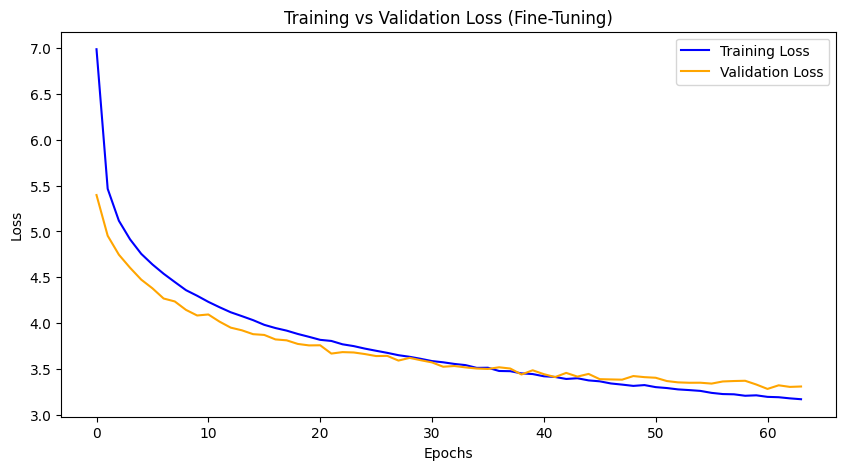

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss_logger, label='Training Loss', color='blue')
plt.plot(val_loss_logger, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss (Fine-Tuning)')
plt.legend()
plt.show()

In [ ]:
import torch
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm
import cv2
import os

checkpoint = torch.load("model_epoch_64.pt") 
model.load_state_dict(checkpoint)
model.eval()
print(" Loaded Model for Evaluation.")

def generate_caption(model, image, vocabulary, max_len=20):
    model.eval()
    image = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        cnn_output = model.cnn_encoder(image)
        cnn_output = cnn_output.view(cnn_output.size(0), -1) 
        encoded_img = model.project(cnn_output).unsqueeze(1)
        
        tgt_indexes = [vocabulary['<START>']]
        
        for _ in range(max_len):
            tgt_tensor = torch.LongTensor(tgt_indexes).unsqueeze(0).to(device)
            seq_len = tgt_tensor.size(1)
            pos_tensor = torch.arange(seq_len, device=device).unsqueeze(0)
            
            tgt_embed = model.word_embeddings(tgt_tensor) + model.pos_embeddings(pos_tensor)
            mask = nn.Transformer.generate_square_subsequent_mask(seq_len).to(device)
            
            output = model.blocks(tgt_embed, encoded_img, tgt_mask=mask)
            output = model.vocab_projection(output)
            
            predicted_token = output[0, -1].argmax().item()
            if predicted_token == vocabulary['<END>']:
                break
            tgt_indexes.append(predicted_token)
            
    return [vocabulary.lookup_token(i) for i in tgt_indexes[1:]]
references = []
hypotheses = []

print("Starting BLEU Evaluation")
unique_test_images = test_df['filename'].unique()

for filename in tqdm(unique_test_images):
    img_path = os.path.join(IMAGES_DIR, filename)
    image = cv2.imread(img_path)
    if image is None: continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    aug = test_dataset.transformations(image=image)
    image_tensor = aug['image'].to(device)
    pred_caption = generate_caption(model, image_tensor, vocabulary)
    hypotheses.append(pred_caption)
    true_captions = test_df[test_df['filename'] == filename]['caption'].values[0]

    ref_tokens = [word_tokenizer(c) for c in true_captions]
    references.append(ref_tokens)
print("\n--- Results ---")
print(f"BLEU-1: {corpus_bleu(references, hypotheses, weights=(1,0,0,0))*100:.2f}")
print(f"BLEU-2: {corpus_bleu(references, hypotheses, weights=(0.5,0.5,0,0))*100:.2f}")
print(f"BLEU-3: {corpus_bleu(references, hypotheses, weights=(0.33,0.33,0.33,0))*100:.2f}")
print(f"BLEU-4: {corpus_bleu(references, hypotheses, weights=(0.25,0.25,0.25,0.25))*100:.2f}")

 Loaded Model for Evaluation.
--- Starting BLEU Evaluation ---


100%|██████████| 2384/2384 [05:15<00:00,  7.56it/s]



--- Results ---
BLEU-1: 60.47
BLEU-2: 41.84
BLEU-3: 28.57
BLEU-4: 19.10


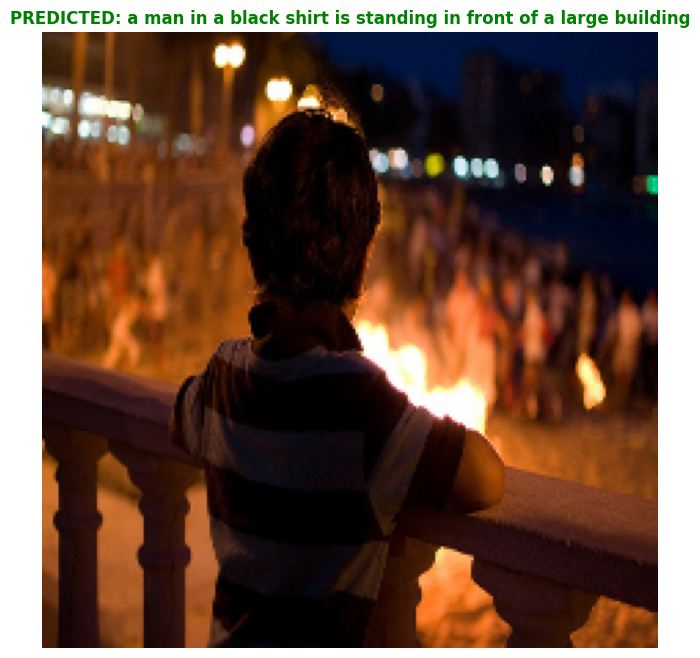

File: 3812719670.jpg
True Captions:
- a little boy in a striped shirt looks out over a railing at a bonfire .
- A child stares down over a group of people who are around a bonfire .
- A young boy in a striped shirt is fixed on the fire below .
--------------------------------------------------


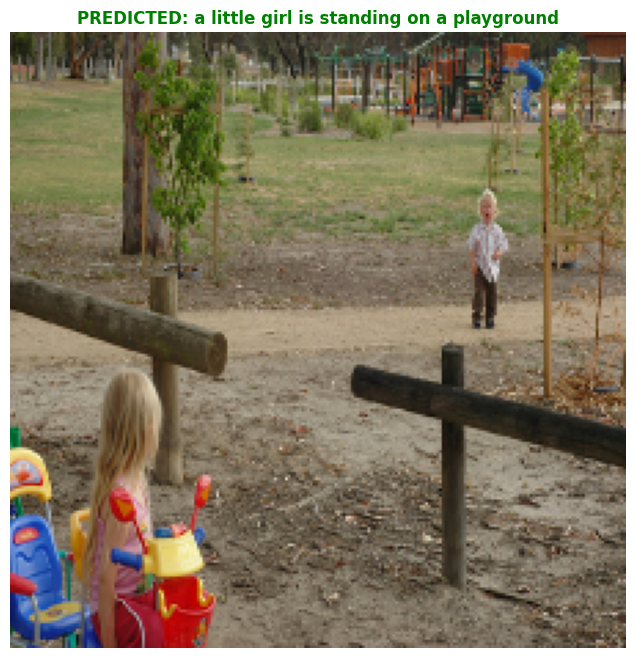

File: 310779961.jpg
True Captions:
- Two young children are at a park  the young boy is crying and the girl is sitting on a colorful children 's vehicle .
- A blond kid wearing a collared shirt and olive green pants cries near a playground .
- A little boy is crying on a playground and a little is riding a toy bike .
--------------------------------------------------


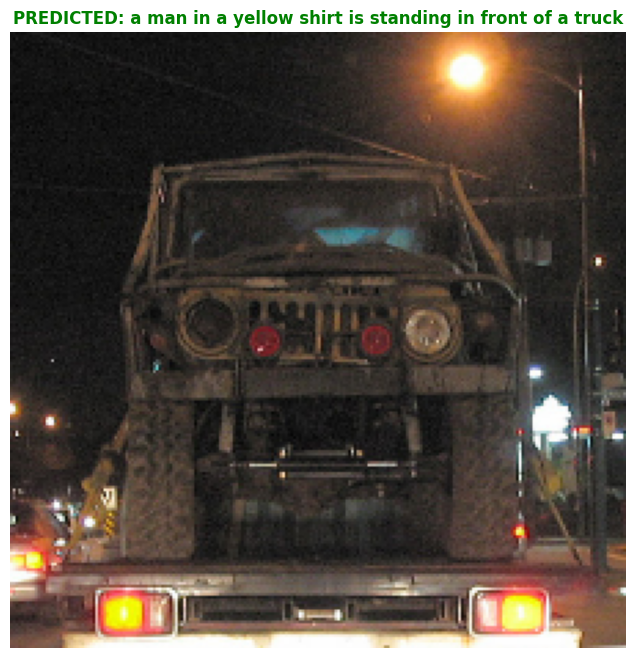

File: 2088460083.jpg
True Captions:
- A damaged vehicle is carried by a repair truck in a nighttime scene .
- A flat bed truck in a parking lot with an army vehicle on its bed .
- Dirty SUV sits on the bed of a tow truck at night .
--------------------------------------------------


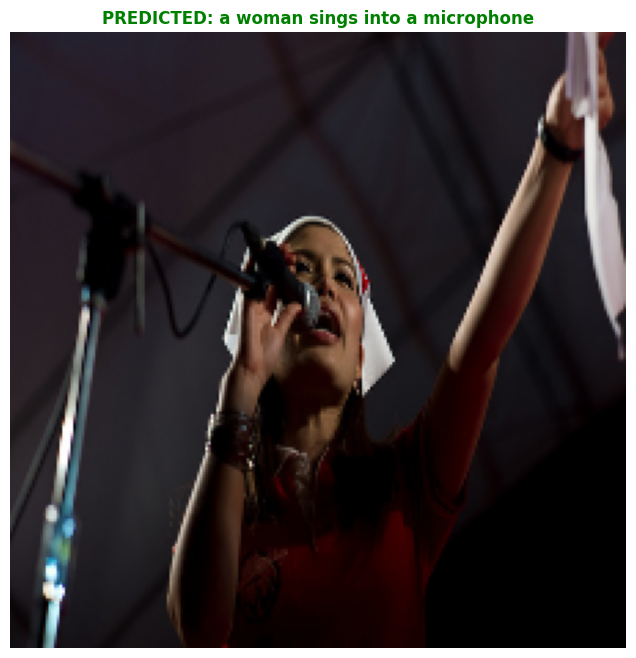

File: 4429900085.jpg
True Captions:
- An attractive woman wearing a bandanna is singing into a microphone .
- A woman in a red shirt speaking into a microphone .
- A woman in a white hat sings into a microphone .
--------------------------------------------------


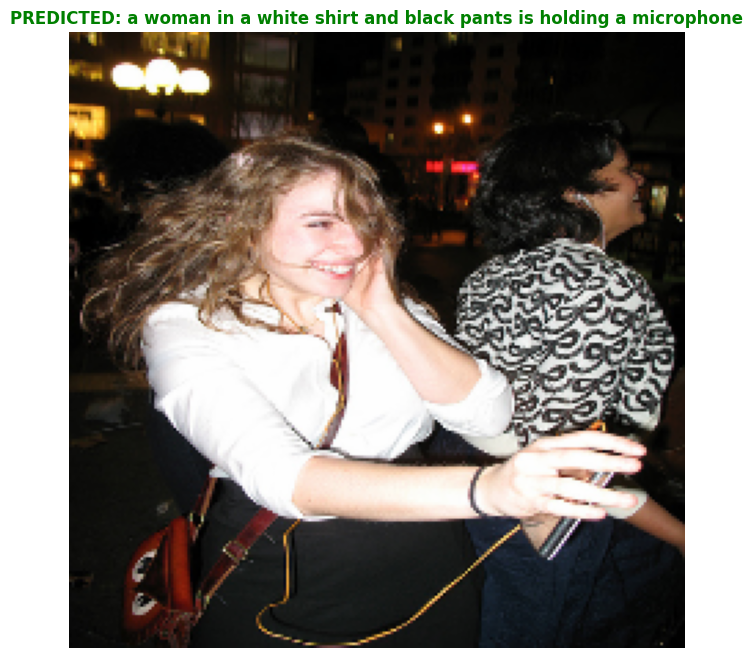

File: 2429366041.jpg
True Captions:
- A woman with brown hair  white blouse  and a red purse is wearing headphones while a black-haired woman in a black and white blouse smiles next to her .
- A woman in a white blouse and a woman in a white blouse with black bows listen to iPods while dancing .
- Two women are smiling as they appear to be listening to portable music devices .
--------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

def visualize_prediction(model, dataset, vocabulary, num_examples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_examples)
    
    for idx in indices:
        image_tensor = dataset[idx][0]
        filename = dataset.df.iloc[idx]['filename']   
        
        pred_caption_tokens = generate_caption(model, image_tensor, vocabulary)
        pred_sentence = " ".join(pred_caption_tokens)
        
        true_captions = dataset.df.iloc[idx]['caption']

        img_display = image_tensor.permute(1, 2, 0).cpu().numpy()
        img_display = img_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406] # Un-Normalize
        img_display = np.clip(img_display, 0, 1)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(img_display)
        plt.axis("off")
        plt.title(f"PREDICTED: {pred_sentence}", color='green', fontsize=12, fontweight='bold')
        plt.show()
        
        print(f"File: {filename}")
        print(f"True Captions:")
        for cap in true_captions[:3]: 
            print(f"- {cap}")

visualize_prediction(model, test_dataset, vocabulary, num_examples=5)